# Resultater, figurer og tabeller

In [1]:
# Importing packages + magics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Importing python module(s)
import model_functions as model

# code for saving figure:
# plt.savefig('figures/cumulative_labor', dpi=300, bbox_inches='tight')

In [3]:
# Plotting settings
import seaborn as sns
sns.set(style='ticks', palette=['#88CCEE','#CC6677','#DDCC77','#117733','#332288','#AA4499','#44AA99','#999933','#882255','#661100','#6699CC','#888888'])

SMALL_SIZE = 10
MEDIUM_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('figure', titlesize=16)  # fontsize of the figure title

## Figur 2: Historisk afkast for fixed-income investeringer

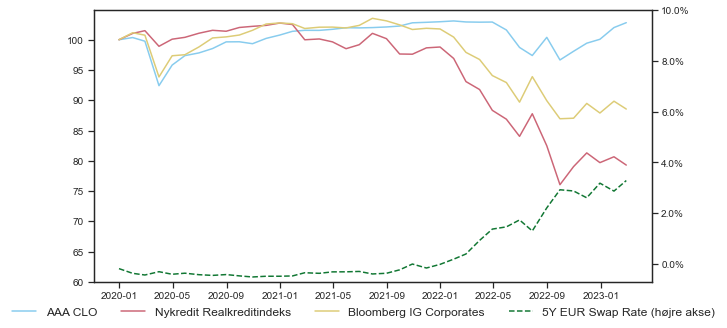

In [3]:
df_fig = pd.read_excel('data\historical_performance.xlsx')
df_fig.set_index('date', inplace=True)

fig, ax1 = plt.subplots(1,1, figsize=(10,5))
ax2 = ax1.twinx() # second y-axis

# plotting on the left axis
ax1.plot(df_fig['CLO_AAA'], label='AAA CLO');
ax1.plot(df_fig['nykredit'], label='Nykredit Realkreditindeks');
ax1.plot(df_fig['bloomberg'], label='Bloomberg IG Corporates');

# plotting on the right axis
ax2._get_lines.prop_cycler = ax1._get_lines.prop_cycler
ax2.plot(df_fig['eur_swap'], label='5Y EUR Swap Rate (højre akse)', linestyle='--')

# additional cosmetics
ax1.set_ylim(bottom=60)
ax2.set_ylim(top=0.10)
ax2.yaxis.set_major_formatter(FuncFormatter('{:.1%}'.format))
fig.legend(loc='lower center', frameon=False, ncol=len(df_fig));
# plt.savefig('figures/yields_and_interest', dpi=300, bbox_inches='tight')

## Figure 3: Illustrativ simulering af en Geometric Brownian Motion

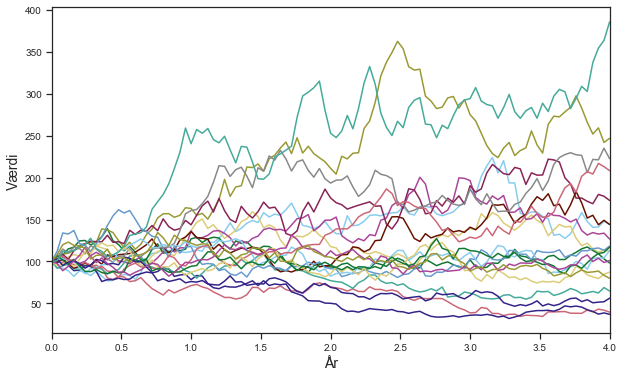

In [4]:
sim_model = model.CLOModel(T=4, n=20) # model instance
time = np.linspace(0, sim_model.T, sim_model.m+1) # time with freq+1 steps
tt = np.full(shape=(sim_model.n, sim_model.m+1), fill_value = time).T
sim_array = sim_model.GBM_fig()

# Plotting
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.plot(tt, sim_array);
ax.set_xlim(0, sim_model.T)
ax.set_xlabel('År');
ax.set_ylabel('Værdi');
# plt.savefig('figures/GBM_simulation', dpi=300, bbox_inches='tight')

## Figur 4: Simuleret fordeling af cashflow til SPV

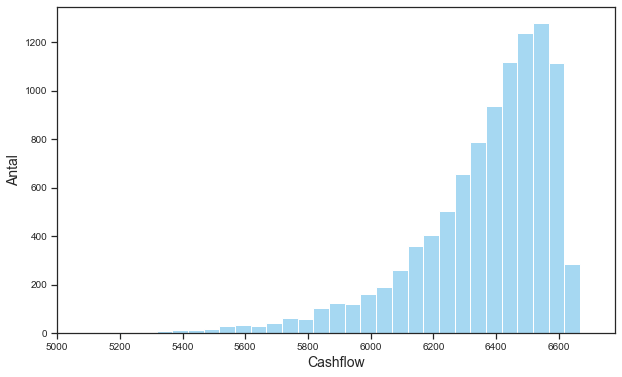

In [12]:
fig_model = model.CLOModel()
data = fig_model.SPV_value()

fig, ax = plt.subplots(1,1, figsize=(10,6))

sns.histplot(data, binwidth=50)
ax.set_xlabel('Cashflow')
ax.set_ylabel('Antal')
ax.set_xlim(left=5000);

# plt.savefig('figures/SPV_cashflow', dpi=300, bbox_inches='tight')

## Figur 5: Fordeling af cashflow til SPV'en under forskellige risikofrie rentesatser

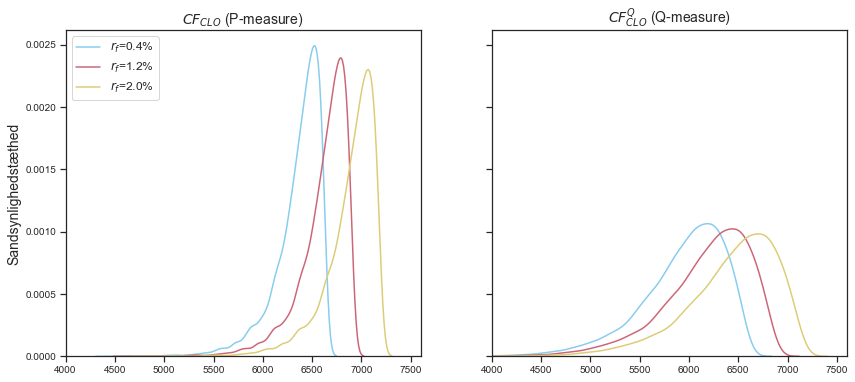

In [4]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6), sharey=True)
rf_array = np.array([0.004, 0.012, 0.02]) # risk free rates

for rate in rf_array:
    fig_model = model.CLOModel(rf=rate)
    SPV_P = fig_model.SPV_value()
    SPV_Q = fig_model.SPV_value(risk_neutral=True)
    sns.kdeplot(SPV_P, ax=ax1, label=f'$r_f$={rate*100}%') # left axis (P-measure)
    sns.kdeplot(SPV_Q, ax=ax2) # right axis (Q-measure)
    # sns.histplot(SPV_P, ax=ax1, label=f'$r_f$={rate*100}%', alpha=0.5)
    # sns.histplot(SPV_Q, ax=ax2, alpha=0.5)
    
ax1.legend()
ax1.set_xlim(left=4000, right=7600)
ax2.set_xlim(left=4000, right=7600)
ax1.set_title('$CF_{CLO}$ (P-measure)')
ax2.set_title('$CF_{CLO}^Q$ (Q-measure)')
ax1.set_ylabel('Sandsynlighedstæthed');

# plt.savefig('figures/SPV_cashflow_rf', dpi=300, bbox_inches='tight')

## Figur 6: Renstestigningers effekt på spreads

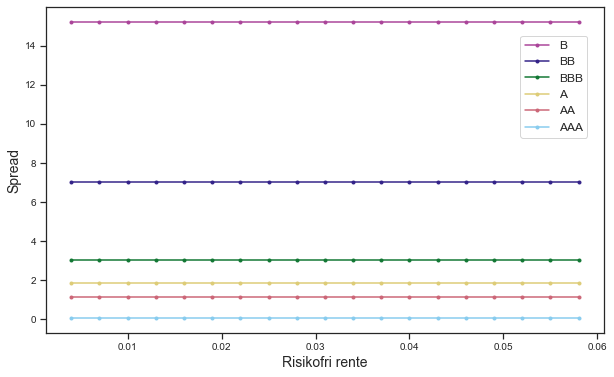

In [37]:
rf_array = np.arange(0.004, 0.06, 0.003)

data_agg = []
for rate in rf_array:
    fig_model = model.CLOModel(rf=rate)
    result_table = fig_model.result_table()
    data_agg.append(result_table['spread'].to_list())
    
data_agg = np.array(data_agg)

fig, ax = plt.subplots(1,1, figsize=(10,6))

for i, rating in enumerate(['AAA', 'AA', 'A', 'BBB', 'BB', 'B']):
    ax.plot(rf_array, data_agg[:,i], marker='.', label=f'{rating}')
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], frameon=True, loc=(0.85, 0.6))
ax.set_ylabel('Spread')
ax.set_xlabel('Risikofri rente')

# plt.savefig('figures/spread_rf_sensitivity', dpi=300, bbox_inches='tight')

## Figur 7: Fordeling af cashflow til CLO'en under forskellige konkursrisici

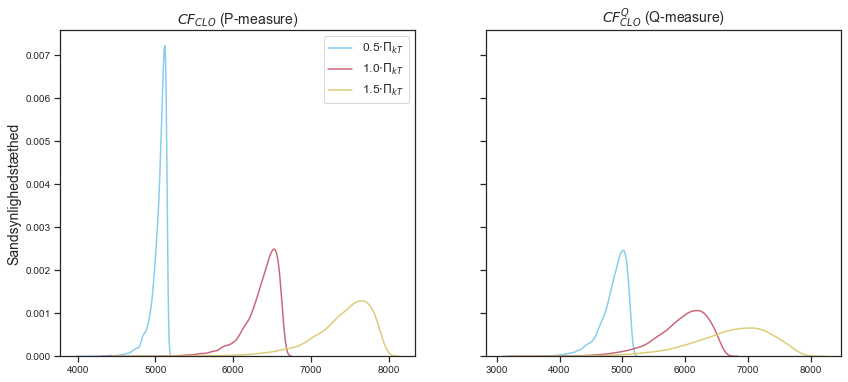

In [41]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6), sharey=True)
scalar_array = np.array([0.5, 1, 1.5]) # risk free rates
base_default = model.CLOModel().load_default() # load baseline default rates

for scalar in scalar_array:
    fig_model = model.CLOModel(default=base_default*scalar)
    SPV_P = fig_model.SPV_value()
    SPV_Q = fig_model.SPV_value(risk_neutral=True)
    sns.kdeplot(SPV_P, ax=ax1, label=f'{scalar}'+'$\cdot \Pi_{kT}$') # left axis (P-measure)
    sns.kdeplot(SPV_Q, ax=ax2) # right axis (Q-measure)
    # sns.histplot(SPV_P, ax=ax1, label=f'$r_f$={rate*100}%', alpha=0.5)
    # sns.histplot(SPV_Q, ax=ax2, alpha=0.5)
    
ax1.legend()
# ax1.set_xlim(left=4000, right=7600)
# ax2.set_xlim(left=4000, right=7600)
ax1.set_title('$CF_{CLO}$ (P-measure)')
ax2.set_title('$CF_{CLO}^Q$ (Q-measure)')
ax1.set_ylabel('Sandsynlighedstæthed');

# plt.savefig('figures/SPV_cashflow_default', dpi=300, bbox_inches='tight')

## Figur 8: Effekten af ændringer i konkursrici på spreads

In [47]:
scalar_array = np.arange(0.5, 2, 0.08)

data_agg = []
base_default = model.CLOModel().load_default() # load baseline default rates

for scalar in scalar_array:
    fig_model = model.CLOModel(n=250000, default=base_default*scalar)
    result_table = fig_model.result_table()
    data_agg.append(result_table['spread'].to_list())
    
data_agg = np.array(data_agg)
data_index = data_agg / data_agg[0,:] * 100

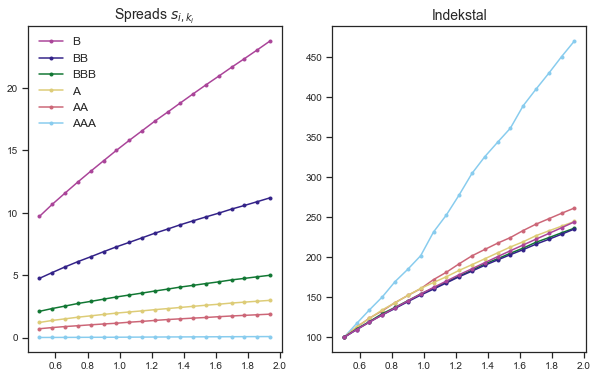

In [49]:
fig, ax = plt.subplots(1,2, figsize=(10,6))

for i, rating in enumerate(['AAA', 'AA', 'A', 'BBB', 'BB', 'B']):
    ax[0].plot(scalar_array, data_agg[:,i], marker='.', label=f'{rating}')
    ax[1].plot(scalar_array, data_index[:,i], marker='.')
    
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], frameon=False)

# ax[0].set_xticks(rf_array)
# ax[1].set_xticks(rf_array)

ax[0].set_title('Spreads $s_{i,k_i}$')
ax[1].set_title('Indekstal');

# plt.savefig('figures/spread_default_sensitivity', dpi=300, bbox_inches='tight')

## Table 3: Resultater fra modelsimulering

In [16]:
fig_model = model.CLOModel()
table = fig_model.result_table()

In [17]:
table.round(2)

,default probability,aggregate face value,aggregate market value,face value,market value,kurs,afkast,spread
Rating,,,,,,,,
AAA,0.09,5018.73,4908.53,5018.73,4908.53,97.80,0.44,0.04
AA,0.30,5279.62,5149.78,260.88,241.24,92.47,1.57,1.17
A,0.44,5356.81,5218.77,77.20,68.99,89.37,2.25,1.85
BBB,1.48,5612.34,5434.03,255.53,215.26,84.24,3.43,3.03
BB,6.19,5934.59,5656.31,322.25,222.28,68.98,7.43,7.03
B,16.67,6167.18,5762.83,232.59,106.52,45.80,15.62,15.22


## SENSITIVITY: rf effekt på face value B-hat

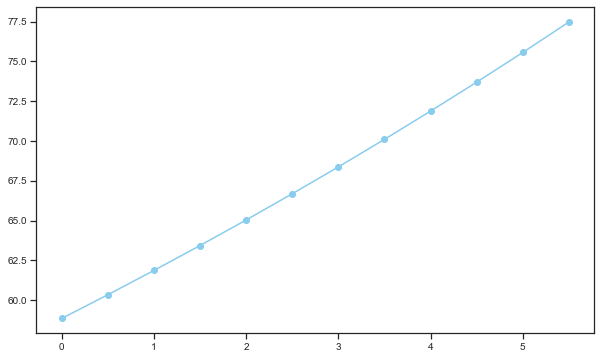

In [87]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
rf_array = np.arange(0, 0.06, step=0.005)
data = np.empty(len(rf_array))

for i, rate in enumerate(rf_array):
    fig_model = model.CLOModel(rf=rate, n=5000)
    data[i] = fig_model.face_value()
    
ax.plot(rf_array*100, data, marker='o')

## SENSITIVITY: rf effekt på SPV cash-flow fordeling (P & Q)

## SENSITIVITY: rf ændring effekt på market value W

In [37]:
# rf_array = np.array([0.004, 0.012, 0.02])
rf_array = np.arange(0.004, 0.06, 0.006)

data_agg = []
data_tranche = []
for rate in rf_array:
    fig_model = model.CLOModel(n=10000, rf=rate)
    result_table = fig_model.result_table()
    data_agg.append(result_table['aggregate market value'].to_list())
    data_tranche.append(result_table['market value'].to_list())
    
data_agg = np.array(data_agg)
data_tranche = np.array(data_tranche)
data_tranche = data_tranche / data_tranche[0,:] * 100

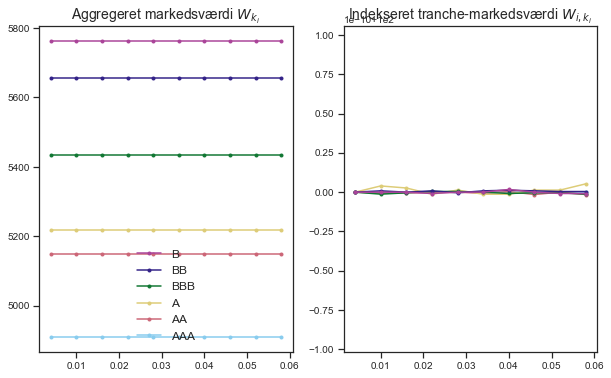

In [38]:
fig, ax = plt.subplots(1,2, figsize=(10,6))

for i, rating in enumerate(['AAA', 'AA', 'A', 'BBB', 'BB', 'B']):
    ax[0].plot(rf_array, data_agg[:,i], marker='.', label=f'{rating}')
    ax[1].plot(rf_array, data_tranche[:,i], marker='.')
    
handles, labels = ax[0].get_legend_handles_labels()
ax[0].legend(handles[::-1], labels[::-1], frameon=False)
# ax[0].set_xticks(rf_array)
# ax[1].set_xticks(rf_array)

ax[0].set_title('Aggregeret markedsværdi $W_{k_i}$')
ax[1].set_title('Indekseret tranche-markedsværdi $W_{i,k_i}$');

## SENSITIVITY: rf effekt på spread/yield

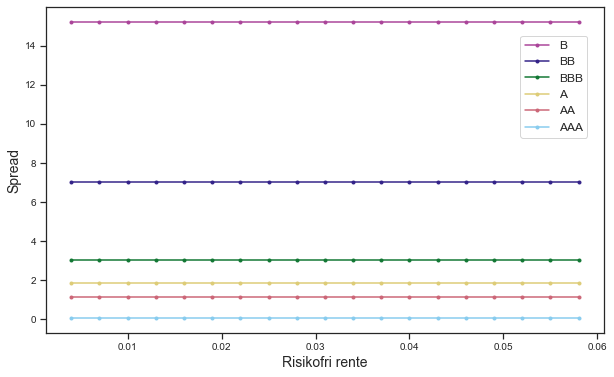

## SENSITIVITY: rf ændring effekt på W/B (markedsværdi / face value)

In [282]:
# rf_array = np.array([0.004, 0.012, 0.02])
rf_array = np.arange(0.004, 0.06, 0.006)

data_agg_W = []
data_agg_B = []
data_tranche_W = []
data_tranche_B = []
for rate in rf_array:
    fig_model = model.CLOModel(n=10000, rf=rate)
    result_table = fig_model.result_table()
    data_agg_W.append(result_table['aggregate market value'].to_list())
    data_agg_B.append(result_table['aggregate face value'].to_list())
    data_tranche_W.append(result_table['market value'].to_list())
    data_tranche_B.append(result_table['face value'].to_list())

data_agg = np.array(data_agg_W) / np.array(data_agg_B)
data_tranche = np.array(data_tranche_W) / np.array(data_tranche_B)
# data_tranche = data_tranche / data_tranche[0,:] * 100

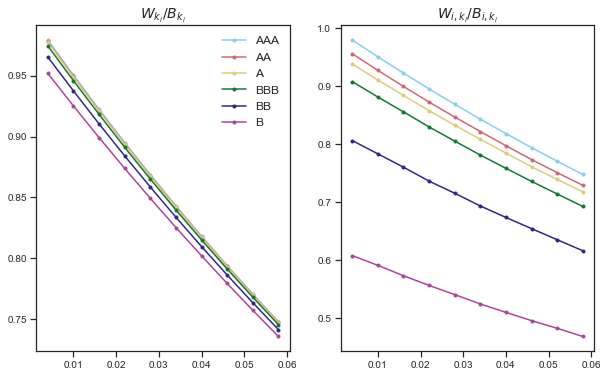

In [284]:
fig, ax = plt.subplots(1,2, figsize=(10,6))

for i, rating in enumerate(['AAA', 'AA', 'A', 'BBB', 'BB', 'B']):
    ax[0].plot(rf_array, data_agg[:,i], marker='.', label=f'{rating}')
    ax[1].plot(rf_array, data_tranche[:,i], marker='.')
    
# handles, labels = ax[0].get_legend_handles_labels()
# ax[0].legend(handles[::-1], labels[::-1], frameon=False)
ax[0].legend(frameon=False)
# ax[0].set_xticks(rf_array)
# ax[1].set_xticks(rf_array)

ax[0].set_title('$W_{k_i} / B_{k_i}$')
ax[1].set_title('$W_{i,k_i} / B_{i,k_i}$');

# Recycle Bin

## Figure 2: SPV cash flow histogram

In [56]:
test = model.CLOModel(rf=0.005)
test.SPV_value()

834328


array([5030.66150542, 5309.74617196, 5318.22568559, ..., 7556.89776587,
       7556.89776587, 7556.89776587])

In [59]:
test = model.CLOModel()
test.default = test.load_default()*2
test.result_table()

,default probability,aggregate face value,aggregate market value,face value,market value,kurs,afkast,spread
Rating,,,,,,,,
AAA,0.1836,6665.889237,6452.612816,6665.889237,6452.612816,96.800481,0.650365,0.250365
AA,0.6000,7159.945044,6846.905624,494.055806,394.292808,79.807342,4.511094,4.111094
A,0.8800,7323.030676,6963.751909,163.085632,116.846285,71.647197,6.668323,6.268323
BBB,2.9600,7871.229463,7294.571855,548.198787,330.819946,60.346712,10.101274,9.701274
BB,12.3800,8650.849751,7580.141945,779.620288,285.570091,36.629382,20.086390,19.686390
B,33.3400,9245.975140,7666.781209,595.125389,86.639263,14.558153,38.540380,38.140380


In [60]:
test = model.CLOModel()
test.result_table()

,default probability,aggregate face value,aggregate market value,face value,market value,kurs,afkast,spread
Rating,,,,,,,,
AAA,0.0918,5686.971293,5537.504278,5686.971293,5537.504278,97.371764,0.532678,0.132678
AA,0.3000,5982.590140,5789.375305,295.618847,251.871027,85.201275,3.203076,2.803076
A,0.4400,6070.063603,5858.600883,87.473462,69.225578,79.138948,4.679301,4.279301
BBB,1.4800,6359.615432,6063.181756,289.551829,204.580873,70.654319,6.947419,6.547419
BB,6.1900,6724.768599,6248.981973,365.153167,185.800217,50.882817,13.512898,13.112898
B,16.6700,6988.332951,6322.954292,263.564352,73.972319,28.066132,25.412132,25.012132


## Figure: Cash flows sensitivity to rf-change

In [60]:
rf_array = np.arange(0.005, 0.06, step=0.005)
rating = 'B'
data = np.empty(len(rf_array))
for i, rate in enumerate(rf_array):
    fig_model = model.CLOModel(rf=rate)
    data_df = fig_model.result_table()
    # print(f'rf={rate}, spread={data_df.loc['AAA', 'spread']}')
    data[i] = data_df.loc[rating, 'spread']

Text(0, 0.5, 'Spread')

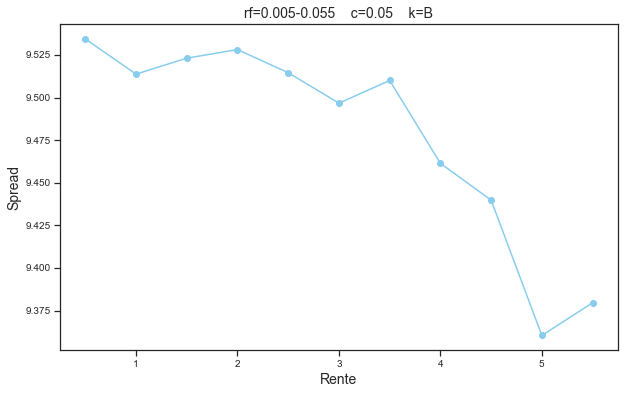

In [61]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

ax.plot(rf_array*100, data, marker='o')
ax.set_title(f'rf={rf_array[0]}-{rf_array[-1]}    c={fig_model.c}    k={rating}')
ax.set_xlabel('Rente')
ax.set_ylabel('Spread')

In [11]:
rf_array = np.arange(0.035, 0.1, step=0.010)

for i, rate in enumerate(rf_array):
    fig_model = model.CLOModel(rf=rate, n=10_000)
    data_df = fig_model.result_table()
    spread = data_df.loc['AAA', 'spread']
    afkast = data_df.loc['AAA', 'afkast']
    print(f'rf={rate:.3f}, spread={spread:.3f}, yield={afkast:.3f}')

rf=0.035, spread=0.001, yield=3.501
rf=0.045, spread=0.001, yield=4.501
rf=0.055, spread=0.001, yield=5.501
rf=0.065, spread=0.001, yield=6.501
rf=0.075, spread=0.001, yield=7.501
rf=0.085, spread=0.001, yield=8.501
rf=0.095, spread=0.000, yield=9.500
